In [189]:
import json
import pandas as pd
from collections import Counter
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import cross_val_score
from scipy.sparse import csr_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification

In [121]:
dom1 = []
dom2 = []
test_set = []
with open('../data/domain1_train.json', 'r') as file:
    for line in file:
        dom1.append(json.loads(line))
        
with open('../data/domain2_train.json', 'r') as file:
    for line in file:
        dom2.append(json.loads(line))
        
sam = pd.read_csv("../data/sample.csv")

with open('../data/test_set.json', 'r') as file:
    for line in file:
        test_set.append(json.loads(line))
        
dom1 = pd.DataFrame.from_dict(dom1)
dom2 = pd.DataFrame.from_dict(dom2)
dom2 = dom2[dom2['text'].apply(len) > 0]
test_set = pd.DataFrame.from_dict(test_set)

# human as model 8, dom1 AI as model 7
dom1['model'] = np.where(dom1['label'] == 1, 8, 7)
dom2["model"] = dom2["model"].replace(np.nan, 8)

df = pd.concat([dom1, dom2])
df = df.sample(frac=1).reset_index(drop=True)
print(len(df))
df_0 = df.loc[df['label']==0]
df_1 = df.loc[df['label']==1]
AI_num = len(df['model'].value_counts()) -1

34399


In [122]:
df1_valid = df_1.groupby('model').apply(lambda x: x.sample(n=int(500)))
df0_valid = df_0.groupby('model').apply(lambda x: x.sample(n=int(500/AI_num)))

df1_valid_index = []
for i in range(len(df1_valid)):
    df1_valid_index.append(df1_valid.index[i][1])
    
df0_valid_index = []
for i in range(len(df0_valid)):
    df0_valid_index.append(df0_valid.index[i][1])
    
df_train = df.drop(df0_valid_index)
df_train = df_train.drop(df1_valid_index)
print(len(df_train))

df1_valid.reset_index(drop=True, inplace=True)
df0_valid.reset_index(drop=True, inplace=True)
df_valid = pd.concat([df1_valid, df0_valid])
print(len(df_valid))
print(len(df_valid)+len(df_train)==34399)

33403
996
True


In [123]:
df0_train = df_train.loc[df_train['label']==0]
df1_train = df_train.loc[df_train['label']==1]

least_mod_num = df0_train['model'].value_counts().tolist()[-1]

In [149]:
df0_train['model'].value_counts()

model
7.0    9688
0.0    2302
3.0    2296
1.0    2295
2.0    2277
6.0    1701
4.0     727
5.0     718
Name: count, dtype: int64

In [237]:
df_all = []
for _ in range(6):
    df0_train_even = df0_train.groupby('model').apply(lambda x: x.sample(n=int(least_mod_num)))
    df0_train_even.reset_index(drop=True, inplace=True)

    df1_train_equal = df1_train.groupby('model').apply(lambda x: x.sample(n=int(least_mod_num*AI_num)))
    df_train = pd.concat([df0_train_even,df1_train_equal])
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_all.append(df_train)

In [238]:
df_all[0]

,text,label,model
0,"[288, 1578, 17, 0, 7, 13, 17, 102, 1086, 4, 14...",0,2.0
1,"[17, 664, 129, 1224, 21, 1847, 24, 193, 1, 14,...",0,6.0
2,"[30, 488, 197, 18, 4, 31, 420, 18, 2, 3577, 6,...",0,7.0
3,"[22, 4050, 7, 241, 0, 2, 1530, 6, 51, 435, 894...",0,1.0
4,"[26, 36, 926, 9, 36, 0, 1, 27, 10, 336, 612, 4...",0,4.0
...,...,...,...
11483,"[20, 38, 1195, 5, 683, 33, 2744, 280, 0, 7, 2,...",0,6.0
11484,"[113, 42, 91, 4, 2, 0, 3206, 615, 3, 42, 271, ...",1,8.0
11485,"[10, 2, 0, 6, 2, 330, 193, 805, 279, 1, 14, 10...",0,4.0
11486,"[0, 418, 17, 689, 2, 671, 1121, 315, 9, 0, 552...",1,8.0


In [219]:
df_all[0]['model'].value_counts()

model
8.0    2872
0.0     359
7.0     359
1.0     359
2.0     359
3.0     359
4.0     359
5.0     359
6.0     359
Name: count, dtype: int64

In [239]:
def to_sparse_matrix(sequences, vocab_size):
    indptr = [0]
    indices = []
    data = []
    for seq in sequences:
        feature_counter = {}
        for index in seq:
            if index != 0:  # Skip 0s, other words
                if index not in feature_counter:
                    feature_counter[index] = 1
                else:
                    feature_counter[index] += 1
        indices.extend(feature_counter.keys())
        data.extend(feature_counter.values())
        indptr.append(len(indices))
    return csr_matrix((data, indices, indptr), dtype=int, shape=(len(sequences), vocab_size + 1))
vocab_size = 4999
X = []
y = []
for i in range(len(df_all)):
    X.append(to_sparse_matrix(df_all[i]['text'], vocab_size))
    y.append(df_all[i]['label'])

In [221]:
X[0]

<5744x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 248524 stored elements in Compressed Sparse Row format>

In [256]:
# # Define a function to create bigrams from a list
# def create_bigrams(numbers):
#     bigrams = []
#     for i in range(len(numbers) - 1):
#         bigram = [numbers[i], numbers[i + 1]]
#         bigrams.append(bigram)
#     return bigrams
# # Apply the create_bigrams function to the 'number_list' column
# df['bigrams'] = df['text'].apply(create_bigrams)

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X[0], y[0], test_size=0.2, random_state=42)

k_values = []
accuracies = []


for k in range(100, (X_train.shape[1] + 1),100):
    # Apply SelectKBest class to extract top k best features
    best_features = SelectKBest(score_func=f_classif, k=k)
    X_train_kbest = best_features.fit_transform(X_train, y_train)
    X_test_kbest = best_features.transform(X_test)
    # train classifier
    classifier = SVC(C=10, gamma=0.001)
    classifier.fit(X_train_kbest, y_train)
    # Predict
    y_pred = classifier.predict(X_test_kbest)
    acc = accuracy_score(y_test, y_pred)
    
    k_values.append(k)
    accuracies.append(acc)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % con

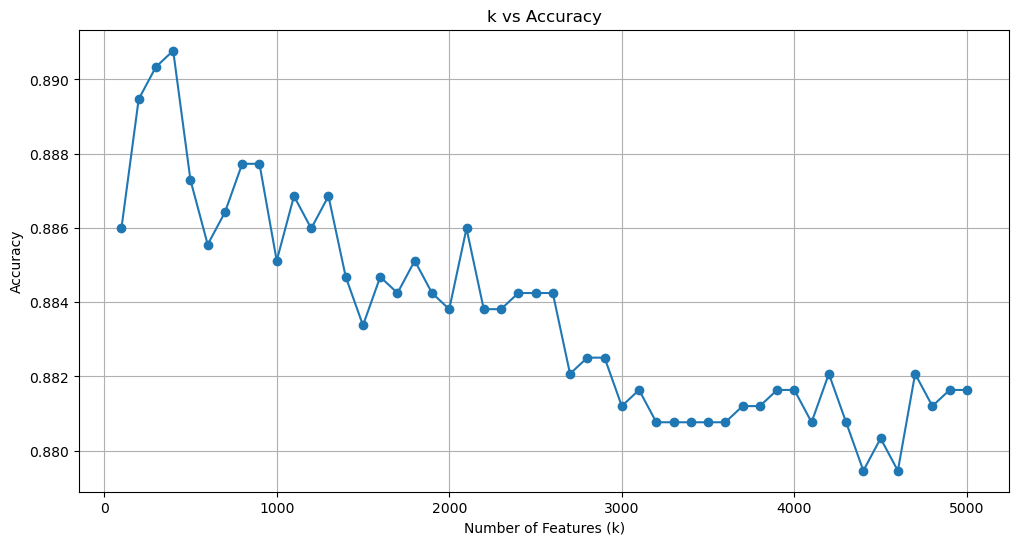

In [242]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.xlabel('Number of Features (k)')
plt.ylabel('Accuracy')
plt.title('k vs Accuracy')
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_sel

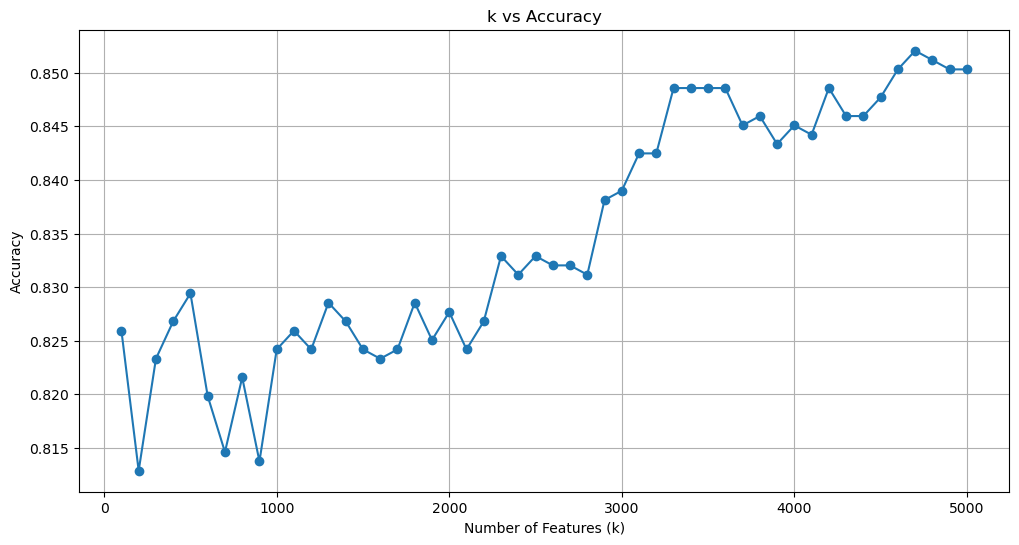

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X[0], y[0], test_size=0.2, random_state=42)
k_values = []
accuracies = []

for k in range(100, (X_train.shape[1] + 1),100):
    # Apply SelectKBest class to extract top k best features
    best_features = SelectKBest(score_func=f_classif, k=k)
    X_train_kbest = best_features.fit_transform(X_train, y_train)
    X_test_kbest = best_features.transform(X_test)
    # train classifier
    classifier = LogisticRegression(solver='liblinear',multi_class='auto', penalty="l2", C=0.5, max_iter=500)#SVC(C=10, gamma=0.001)
    classifier.fit(X_train_kbest, y_train)
    # Predict
    y_pred = classifier.predict(X_test_kbest)
    acc = accuracy_score(y_test, y_pred)
    k_values.append(k)
    accuracies.append(acc)
    
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.xlabel('Number of Features (k)')
plt.ylabel('Accuracy')
plt.title('k vs Accuracy')
plt.grid(True)
plt.show()

In [260]:
# Assuming X is your feature matrix (n-grams) and y is your target variable (labels)
# model = LogisticRegression(penalty='l2', C=0.1)
# sfm = SelectFromModel(model, max_features=2500) 
best_features = SelectKBest(score_func=f_classif, k=2500)
X_new = []
for i in range(len(df_all)):
    X_new.append(best_features.fit_transform(X[i], y[i]))

X_valid = to_sparse_matrix(df_valid['text'], vocab_size)
X_valid = best_features.transform(X_valid)
y_valid = df_valid['label']

X_pre = to_sparse_matrix(test_set['text'], vocab_size)
X_pre_new = best_features.transform(X_pre)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx

In [261]:
X_new

[<11488x2500 sparse matrix of type '<class 'numpy.int64'>'
 	with 428678 stored elements in Compressed Sparse Row format>,
 <11488x2500 sparse matrix of type '<class 'numpy.int64'>'
 	with 420665 stored elements in Compressed Sparse Row format>,
 <11488x2500 sparse matrix of type '<class 'numpy.int64'>'
 	with 430607 stored elements in Compressed Sparse Row format>,
 <11488x2500 sparse matrix of type '<class 'numpy.int64'>'
 	with 425006 stored elements in Compressed Sparse Row format>,
 <11488x2500 sparse matrix of type '<class 'numpy.int64'>'
 	with 432051 stored elements in Compressed Sparse Row format>,
 <11488x2500 sparse matrix of type '<class 'numpy.int64'>'
 	with 425308 stored elements in Compressed Sparse Row format>]

In [485]:
# selector = SelectKBest(chi2, k=1500)
# X_new = selector.fit_transform(X, y)

# X_pre = to_sparse_matrix(test_set['text'], vocab_size)
# X_pre_new = selector.transform(X_pre)

# X_pre = to_sparse_matrix(test_set['text'], vocab_size)
# X_pre_new = selector.transform(X_pre)

In [285]:
# selector = SelectKBest(chi2, k=5000)
# X_new = selector.fit_transform(X, y)

# X_pre = to_sparse_matrix(test_set['text'], vocab_size)
# X_pre_new = selector.transform(X_pre)

In [281]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler(with_mean=False)  # Use with_mean=False for sparse data
# X_new = scaler.fit_transform(X_new)

In [262]:
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Loop through each dataset and perform train-test splitting
for i in range(len(df_all)):
    X_train, X_test, y_train, y_test = train_test_split(
        X_new[i], y[i], test_size=0.2, random_state=42
    )
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

In [263]:
# train a logistic regression model on the training set
multi_svm = svm.SVC(C=10, gamma=0.001)#.fit(X_train, y_train)
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(multi_svm, X_new[0], y[0], scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.883 (0.007)


In [264]:
multi_svm = svm.SVC(C=10, gamma=0.001).fit(X_train, y_train)
# Evaluation
y_pred_train = multi_svm.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
y_pred_test = multi_svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
y_pred_valid = multi_svm.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, y_pred_valid))

Accuracy: 0.9373231773667029
Accuracy: 0.8733681462140992
Accuracy: 0.8835341365461847


In [265]:
test_pre = multi_svm.predict(X_pre_new)
result = pd.DataFrame({
    'class': test_pre,
})
result['id'] = result.index
result = result[['id'] + [col for col in result.columns if col != 'id']]
result['class'].value_counts()

class
0    617
1    383
Name: count, dtype: int64

In [259]:
result.to_csv('result_svm.csv', index=False)

In [407]:

grid={"C":np.logspace(-3,3,7), "penalty":["l2"], "solver":['liblinear','newton-cg'], 'class_weight':[{ 0:0.95, 1:0.05 }, { 0:0.55, 1:0.45 }, { 0:0.45, 1:0.55 },{ 0:0.05, 1:0.95 }]}# l1 lasso l2 ridge
#logreg=LogisticRegression(solver = 'liblinear')
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=3,scoring='f1_micro')
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'class_weight': [{0: 0.95, 1: 0.05},
                                          {0: 0.55, 1: 0.45},
                                          {0: 0.45, 1: 0.55},
                                          {0: 0.05, 1: 0.95}],
                         'penalty': ['l2'],
                         'solver': ['liblinear', 'newton-cg']},
             scoring='f1_micro')

In [400]:
# Grid search cross validation
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.73609397247271


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:


In [472]:
model_log = LogisticRegression(solver='liblinear',multi_class='auto', penalty="l2", C=1, max_iter=100).fit(X_train, y_train)
# Evaluation
y_pred_train = model_log.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
y_pred_test = model_log.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
y_pred_valid = model_log.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, y_pred_valid))

Accuracy: 0.9252254873436137
Accuracy: 0.7479674796747967
Accuracy: 0.7385554425228891


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

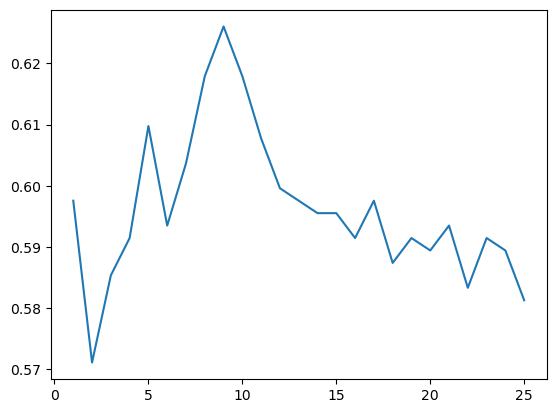

In [409]:

k_range = list(range(1, 26))
scores = []
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
plt.plot(k_range, scores)
plt.show()

In [410]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 9, metric = 'minkowski', p = 2).fit(X_train, y_train)
# Evaluation
y_pred_train = knn_model.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
y_pred_test = knn_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
y_pred_valid = knn_model.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, y_pred_valid))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Accuracy: 0.6848996217631655
Accuracy: 0.6260162601626016
Accuracy: 0.590030518819939


In [393]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   4.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   4.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   7.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

In [394]:
model_rf = RandomForestClassifier(n_estimators=800, criterion='entropy', min_samples_split=5, min_samples_leaf=1,
                                  max_features='sqrt',max_depth= 100,bootstrap= False).fit(X_train, y_train)
# Evaluation
y_pred_train = model_rf.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
y_pred_test = model_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
y_pred_valid = model_rf.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, y_pred_valid))

Accuracy: 0.9959266802443992
Accuracy: 0.6869918699186992
Accuracy: 0.6856561546286877


In [378]:

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(X_train.toarray(), y_train)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 1.873817422860383e-06}

In [229]:
model_gnb = GaussianNB(var_smoothing = 1.873817422860383e-06).fit(X_train.toarray(), y_train)
# Evaluation
y_pred_train = model_gnb.predict(X_train.toarray())
print("Accuracy:", accuracy_score(y_train, y_pred_train))
y_pred_test = model_gnb.predict(X_test.toarray())
print("Accuracy:", accuracy_score(y_test, y_pred_test))
y_pred_valid = model_gnb.predict(X_valid.toarray())
print("Accuracy:", accuracy_score(y_valid, y_pred_valid))

Accuracy: 0.8108813928182808
Accuracy: 0.7432550043516101
Accuracy: 0.7158634538152611


In [230]:

model_mplc = MLPClassifier(activation= 'relu',solver='adam', alpha=0.0001, hidden_layer_sizes=(20,), random_state=1,
                      learning_rate='adaptive').fit(X_train, y_train)
# Evaluation
y_pred_train = model_mplc.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
y_pred_test = model_mplc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
y_pred_valid = model_mplc.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, y_pred_valid))

Accuracy: 0.9995647442872688
Accuracy: 0.8738033072236727
Accuracy: 0.8142570281124498


In [383]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multi

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [384]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [231]:


model = MLPClassifier(activation= 'relu',solver='adam', alpha=0.0001, hidden_layer_sizes=(20,), random_state=1,
                      learning_rate='adaptive')#.fit(X_train, y_train)
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(model, X_new, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: nan (nan)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
TypeError: float() argument must be a string or a number, not 'csr_matrix'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  

In [267]:
estimators = {
        ('gnb', GaussianNB(var_smoothing = 1.873817422860383e-06).fit(X_train_list[0].toarray(), y_train_list[0])),
       
        #('rf',RandomForestClassifier(n_estimators=800, criterion='entropy', min_samples_split=5, min_samples_leaf=1,
                                  #max_features='sqrt',max_depth= 100,bootstrap= False).fit(X_train_list[1], y_train_list[1])),
        
        ('svm', svm.SVC(C=20, gamma=0.0001).fit(X_train_list[2], y_train_list[2])),
        
        #('knn', KNeighborsClassifier(n_neighbors = 9, metric = 'minkowski', p = 2).fit(X_train_list[3], y_train_list[3])),
        
        ('mlpc', MLPClassifier(activation= 'relu',solver='adam', alpha=0.0001, hidden_layer_sizes=(20,), random_state=1,
                      learning_rate='adaptive').fit(X_train_list[4], y_train_list[4]))
    }
stack_para = StackingClassifier(
        estimators=estimators, final_estimator=LogisticRegression(solver='liblinear',multi_class='auto', penalty="l2", C=0.5, max_iter=100))
stack = stack_para.fit(X_train_list[5].toarray(), y_train_list[5])

In [269]:
# Evaluation
y_pred_train = stack.predict(X_train.toarray())
print("Accuracy:", accuracy_score(y_train, y_pred_train))
y_pred_test = stack.predict(X_test.toarray())
print("Accuracy:", accuracy_score(y_test, y_pred_test))
y_pred_valid = stack.predict(X_valid.toarray())
print("Accuracy:", accuracy_score(y_valid, y_pred_valid))

Accuracy: 0.933297062023939
Accuracy: 0.8677110530896431
Accuracy: 0.8775100401606426


In [270]:
test_pre = stack.predict(X_pre_new.toarray())
result = pd.DataFrame({
    'class': test_pre,
})
result['id'] = result.index
result = result[['id'] + [col for col in result.columns if col != 'id']]
result['class'].value_counts()

class
0    633
1    367
Name: count, dtype: int64

In [235]:
result.to_csv('result_stack.csv', index=False)

In [66]:
# from sklearn. metrics import classification_report
# y_pred = multi_svm.predict(X_test)
# print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.72      0.70       249
           1       0.70      0.67      0.68       243

    accuracy                           0.70       492
   macro avg       0.70      0.69      0.69       492
weighted avg       0.70      0.70      0.69       492



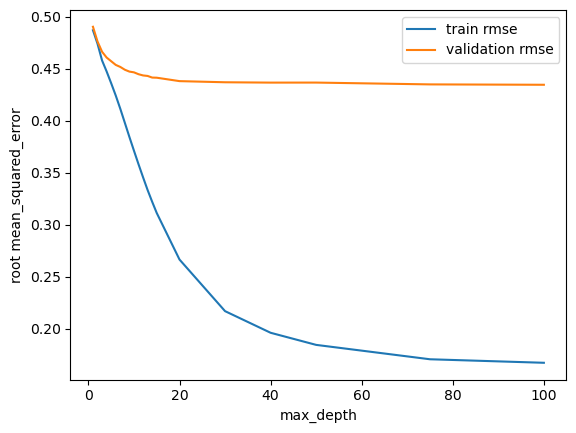

In [61]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
train_errors = []
valid_errors = []
param_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,40,50,75,100]

for max_depth in param_range:
    random_forest = RandomForestRegressor(max_depth=max_depth, n_estimators=100, random_state=1)
    random_forest.fit(X_train, y_train)
    
    train_errors.append(np.sqrt(mean_squared_error(y_train, random_forest.predict(X_train))))
    valid_errors.append(np.sqrt(mean_squared_error(y_test, random_forest.predict(X_test))))
    

plt.xlabel('max_depth')
plt.ylabel('root mean_squared_error')
plt.plot(param_range, train_errors, label="train rmse")
plt.plot(param_range, valid_errors, label="validation rmse")
plt.legend()
plt.show()